In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import calendar
import requests
from sklearn.compose import ColumnTransformer

## plotly dash

- created a page called p1_world.py for the whole map

- created a page called p2_country.py

In [2]:
def read_file(file_path, year_from=2003):
    # Define the number of rows to skip
    num_rows_to_skip = 6
    # Read the Excel file, skipping the specified number of rows
    df = pd.read_excel(file_path, skiprows=num_rows_to_skip)
    
    df_temp = df[df["Disaster Type"]=="Extreme temperature "]
    df_heat = df_temp[df_temp['Disaster Subtype']=='Heat wave']
    
    df_heat_recent = df_heat[df_heat['Year']>=year_from]
    
    print("there are " + str(df_heat_recent.shape[0]) + " heatwave events")
    return df_heat_recent

In [3]:
# world
directory = '../data/raw/'
df_heat = read_file(directory + 'emdat_public_2023_08_18_query_uid-susUgT.xlsx')
df_heat.head()

Workbook contains no default style, apply openpyxl's default


there are 165 heatwave events


,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
59,2003-0391-AUT,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,280000.0,445445.0,62.858460,1,478;479;480;481;482;483;484;485;486,NaN,"Burgenland, Karnten, Niederosterreich, Oberost..."
71,2003-0391-BEL,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.858460,1,600;601;602,NaN,Region de Bruxelles-Capitale / Brussels Hoofds...
117,2004-0333-ALB,2004,333,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64.541329,2,NaN,3819,Durres (Adm2).
195,2003-0391-CHE,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,280000.0,445445.0,62.858460,1,2807;2808;2809;2810;2811;2812;2813;2814;2815;2...,NaN,"Aargau, Appenzell Ausser-rhoden, Appenzell Inn..."
196,2003-0391-DEU,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,10000.0,15909.0,1650000.0,2624945.0,62.858460,1,1308;1309;1310;1311;1312;1313;1314;1315;1316;1...,NaN,"Baden-Wuerttemberg, Bayern, Berlin, Brandenbur..."


In [4]:
def countries_with_min_no_heatwaves(df_heat, threshold=3):
    select = df_heat.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    return len(select[select['Year']>=threshold])

top = countries_with_min_no_heatwaves(df_heat, threshold=3)
top

18

In [5]:
def heatwave_top_countries(df, top=None):
    df_sorted = df.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    
    if top == None:
        return_top = len(df_sorted) 
    else:
        return_top = top
#     plt.barh(df_sorted.Country, df_sorted.Year, color=['red' if country in df_sorted.iloc[:return_top]['Country'].values else 'blue' for country in df_sorted.Country])
#     plt.title('No. heatwaves per country')
    
    focus = list(df_sorted.iloc[:return_top]['Country'])
    top_country_data = df[df['Country'].isin(focus)] 
    print(top_country_data.shape)
    return top_country_data

In [6]:
top_countries = heatwave_top_countries(df_heat, top)

(119, 50)


In [7]:
def plot_deaths_overtime(df):
    '''
    Missing data are now considered and plotted as grey dots
    '''
    data = df.groupby('Year')["Total Deaths"].sum().reset_index()

    plt.figure(figsize=(10, 6))

    plt.plot(data['Year'], data['Total Deaths'], marker='o', linestyle='-', color='blue', label='Total Deaths')
    
    # Identify missing years and plot grey dots for them
    all_years = np.arange(data['Year'].min(), data['Year'].max() + 1)
    missing_years = np.setdiff1d(all_years, data['Year'])
    if len(missing_years) > 0:
        missing_data = np.zeros(len(missing_years))
        plt.scatter(missing_years, missing_data, color='grey', marker='o', label='Missing Years')

    plt.xlabel('Year')
    plt.ylabel('Total Deaths')
    plt.title('Line Chart with Deaths')
    
    # Set x-axis ticks to include all years
    plt.xticks(all_years)

    plt.legend()
    plt.show()

In [8]:
# plot_deaths_overtime(top_countries)

# as we have better equipment to protect from disaster the number of death can be decreasing

In [9]:
top_countries_valid_death = top_countries[~top_countries['Total Deaths'].isna()]#.shape

In [11]:
# Define a custom transformer to process Eurostat features
class EurostatFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, files, two_to_three_iso):
        self.files = files
        self.two_to_three_iso = two_to_three_iso

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_features = X[['ISO']].copy()

        for file in self.files:
            df_health = pd.read_csv(directory + file + '.csv')
            
            if file == 'disabled':
                df_health = df_health[df_health['assist'] == 'TOTAL']

            df_health['geo'] = df_health['geo'].map(self.two_to_three_iso)
            df_health_2022 = df_health[df_health['TIME_PERIOD'] == df_health['TIME_PERIOD'].max()]
            df_filtered = df_health_2022[['geo', 'OBS_VALUE']]
            df_filtered.columns = ['ISO', file]
            new_features = pd.merge(new_features, df_filtered, how='left', on='ISO')
        
        new_features = new_features.drop_duplicates(keep='first')
        return pd.merge(X, new_features, how='left', on='ISO')


# Custom transformer to find non-constant columns
class NonConstantColumnSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = []
        for column in X.columns:
            unique_values = X[column].nunique()

            if unique_values > 1:
                result.append(column)
        
        return X[result]

# Custom transformer to remove columns with all NA values
class RemoveColumnsWithAllNA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_keep = X.columns[X.notna().any()]
        return self

    def transform(self, X):
        return X[self.columns_to_keep]

class CalculateDuration(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()

        mask = X_copy['Start Day'].notna() & X_copy['End Day'].notna()

        X_copy['Start Date'] = pd.to_datetime(dict(year=X_copy['Start Year'], month=X_copy['Start Month'], day=X_copy['Start Day']))
        X_copy['End Date'] = pd.to_datetime(dict(year=X_copy['End Year'], month=X_copy['End Month'], day=X_copy['End Day']))
        X_copy['Duration'] = X_copy['End Date'] - X_copy['Start Date']
        
        X_copy['Duration'] = X_copy['Duration'].apply(lambda x: x.days if not pd.isnull(x) else np.nan)

        return X_copy
    
# Create a FunctionTransformer for filtering
filter_continent = FunctionTransformer(lambda df: df[df['Continent'] == 'Europe'], validate=False)

remove_na_cpi = FunctionTransformer(lambda df: df.dropna(subset=['CPI']), validate=False)


# Define the files and ISO code mapping function
files = ['poverty', 'housing_deprive', 'forest', 'elder', 'population', 'gdp',
         'unemployment', 'child_population', 'disabled']

two_to_three_iso = two_to_three_iso = {
    'GB': 'GBR',
    'AL': 'ALB',
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'CY': 'CYP',
    'CZ': 'CZE',
    'DE': 'DEU',
    'DK': 'DNK',
    'EE': 'EST',
    'EL': 'GRC',
    'ES': 'ESP',
    'FI': 'FIN',
    'FR': 'FRA',
    'HR': 'HRV',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LT': 'LTU',
    'LU': 'LUX',
    'LV': 'LVA',
    'MT': 'MLT',
    'NL': 'NLD',
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SE': 'SWE',
    'SI': 'SVN',
    'SK': 'SVK'
}

# Create a Pipeline
pipeline = Pipeline(steps=[
    ('continent_selector', filter_continent),
    ('remove_na_cpi', remove_na_cpi),
    ('remove_na_col', RemoveColumnsWithAllNA()),
    ('calculate_duration', CalculateDuration()),
    ('non_constant_col_selector', NonConstantColumnSelector()),
    ('eurostat_features', EurostatFeatureExtractor(files=files, two_to_three_iso=two_to_three_iso))
])

# Transform the DataFrame using the Pipeline and return the transformed DataFrame
transformed_df = pipeline.fit_transform(top_countries_valid_death)

In [12]:
# heatmap_data = dfs.pivot_table(index='Country', columns='Year', values='Total Deaths', aggfunc='sum')

# # Create a heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
# plt.title('Number of Deaths by Country and Year')
# plt.xlabel('Year')
# plt.ylabel('Country')
# plt.show()

In [13]:
# # dfs_europe = dfs[dfs['Region']=='Western Europe']
# def world_map(df, year):
#     # Erstellung der Karte
#     # Standorte = Alpha-3-Code für jedes Land
    
#     df = df[df['Year']==year]
#     print(df.shape)
    
#     fig = px.choropleth(df, locations='ISO', color='Total Deaths',
#                         color_continuous_scale='RdYlGn_r', template="plotly_dark",
#                         title="Weltweiter Death Counts in " + str(year))
    
#     # setzen der Mapbox
#     # Stelle den Zoom ein, wenn das Diagramm angezeigt wird
#     fig.update_layout(mapbox_style="carto-positron",
#                       mapbox_zoom=10)
#     # Titel
#     fig.update_layout(title_x=0.5, margin={"r":0, "t":30,"l":0,"b":0})
    
#     # Display the figure
#     fig.show()

In [14]:
# world_map(dfs, 2003)

In [15]:
# def europe_map(df, year):
#     fig = px.choropleth(df, locations='ISO', color='Total Deaths',
#                         color_continuous_scale='RdYlGn_r', template="plotly_dark",
#                         title="European Death Counts in " + str(year))

#     # Define the boundary coordinates for Europe
#     europe_boundary = {
#         "type": "Feature",
#         "geometry": {
#             "type": "Polygon",
#             "coordinates": [
#                 [
#                     [-20, 35],
#                     [40, 35],
#                     [40, 70],
#                     [-20, 70],
#                     [-20, 35]
#                 ]
#             ]
#         }
#     }

#     # Add boundary shape to the map
#     fig.add_shape(type="line",
#                   x0=-20, y0=35, x1=40, y1=35,
#                   line=dict(color="blue", width=2))

#     fig.update_geos(
#         fitbounds="locations",
#         visible=False,  # Hide the world map
#         showcoastlines=False,  # Hide coastlines
#         projection_scale=1,  # Adjust scale if needed
#         center={"lat": 52.0, "lon": 10.0},  # Adjust center as needed
#         scope="europe",  # Set the map scope to Europe
#     )

#     fig.update_layout(title_x=0.5, margin={"r": 0, "t": 30, "l": 0, "b": 0})

#     fig.show()

# # Call the function
# europe_map(dfs, 2003)

# Weather

In [16]:
capitals=[{"CountryName":"Somaliland",
           "CapitalName":"Hargeisa","CapitalLatitude":"9.55","CapitalLongitude":"44.050000","CountryCode":"NULL","ContinentName":"Africa"},{"CountryName":"South Georgia and South Sandwich Islands","CapitalName":"King Edward Point","CapitalLatitude":"-54.283333","CapitalLongitude":"-36.500000","CountryCode":"GS","ContinentName":"Antarctica"},{"CountryName":"French Southern and Antarctic Lands","CapitalName":"Port-aux-FranÃ§ais","CapitalLatitude":"-49.35","CapitalLongitude":"70.216667","CountryCode":"TF","ContinentName":"Antarctica"},{"CountryName":"Palestine","CapitalName":"Jerusalem","CapitalLatitude":"31.766666666666666","CapitalLongitude":"35.233333","CountryCode":"PS","ContinentName":"Asia"},{"CountryName":"Aland Islands","CapitalName":"Mariehamn","CapitalLatitude":"60.116667","CapitalLongitude":"19.900000","CountryCode":"AX","ContinentName":"Europe"},{"CountryName":"Nauru","CapitalName":"Yaren","CapitalLatitude":"-0.5477","CapitalLongitude":"166.920867","CountryCode":"NR","ContinentName":"Australia"},{"CountryName":"Saint Martin","CapitalName":"Marigot","CapitalLatitude":"18.0731","CapitalLongitude":"-63.082200","CountryCode":"MF","ContinentName":"North America"},{"CountryName":"Tokelau","CapitalName":"Atafu","CapitalLatitude":"-9.166667","CapitalLongitude":"-171.833333","CountryCode":"TK","ContinentName":"Australia"},{"CountryName":"Western Sahara","CapitalName":"El-AaiÃºn","CapitalLatitude":"27.153611","CapitalLongitude":"-13.203333","CountryCode":"EH","ContinentName":"Africa"},{"CountryName":"Afghanistan","CapitalName":"Kabul","CapitalLatitude":"34.516666666666666","CapitalLongitude":"69.183333","CountryCode":"AF","ContinentName":"Asia"},{"CountryName":"Albania","CapitalName":"Tirana","CapitalLatitude":"41.31666666666667","CapitalLongitude":"19.816667","CountryCode":"AL","ContinentName":"Europe"},{"CountryName":"Algeria","CapitalName":"Algiers","CapitalLatitude":"36.75","CapitalLongitude":"3.050000","CountryCode":"DZ","ContinentName":"Africa"},{"CountryName":"American Samoa","CapitalName":"Pago Pago","CapitalLatitude":"-14.266666666666667","CapitalLongitude":"-170.700000","CountryCode":"AS","ContinentName":"Australia"},{"CountryName":"Andorra","CapitalName":"Andorra la Vella","CapitalLatitude":"42.5","CapitalLongitude":"1.516667","CountryCode":"AD","ContinentName":"Europe"},{"CountryName":"Angola","CapitalName":"Luanda","CapitalLatitude":"-8.833333333333334","CapitalLongitude":"13.216667","CountryCode":"AO","ContinentName":"Africa"},{"CountryName":"Anguilla","CapitalName":"The Valley","CapitalLatitude":"18.216666666666665","CapitalLongitude":"-63.050000","CountryCode":"AI","ContinentName":"North America"},{"CountryName":"Antigua and Barbuda","CapitalName":"Saint John's","CapitalLatitude":"17.116666666666667","CapitalLongitude":"-61.850000","CountryCode":"AG","ContinentName":"North America"},{"CountryName":"Argentina","CapitalName":"Buenos Aires","CapitalLatitude":"-34.583333333333336","CapitalLongitude":"-58.666667","CountryCode":"AR","ContinentName":"South America"},{"CountryName":"Armenia","CapitalName":"Yerevan","CapitalLatitude":"40.166666666666664","CapitalLongitude":"44.500000","CountryCode":"AM","ContinentName":"Europe"},{"CountryName":"Aruba","CapitalName":"Oranjestad","CapitalLatitude":"12.516666666666667","CapitalLongitude":"-70.033333","CountryCode":"AW","ContinentName":"North America"},{"CountryName":"Australia","CapitalName":"Canberra","CapitalLatitude":"-35.266666666666666","CapitalLongitude":"149.133333","CountryCode":"AU","ContinentName":"Australia"},{"CountryName":"Austria","CapitalName":"Vienna","CapitalLatitude":"48.2","CapitalLongitude":"16.366667","CountryCode":"AT","ContinentName":"Europe"},{"CountryName":"Azerbaijan","CapitalName":"Baku","CapitalLatitude":"40.38333333333333","CapitalLongitude":"49.866667","CountryCode":"AZ","ContinentName":"Europe"},{"CountryName":"Bahamas","CapitalName":"Nassau","CapitalLatitude":"25.083333333333332","CapitalLongitude":"-77.350000","CountryCode":"BS","ContinentName":"North America"},{"CountryName":"Bahrain","CapitalName":"Manama","CapitalLatitude":"26.233333333333334","CapitalLongitude":"50.566667","CountryCode":"BH","ContinentName":"Asia"},{"CountryName":"Bangladesh","CapitalName":"Dhaka","CapitalLatitude":"23.716666666666665","CapitalLongitude":"90.400000","CountryCode":"BD","ContinentName":"Asia"},{"CountryName":"Barbados","CapitalName":"Bridgetown","CapitalLatitude":"13.1","CapitalLongitude":"-59.616667","CountryCode":"BB","ContinentName":"North America"},{"CountryName":"Belarus","CapitalName":"Minsk","CapitalLatitude":"53.9","CapitalLongitude":"27.566667","CountryCode":"BY","ContinentName":"Europe"},{"CountryName":"Belgium","CapitalName":"Brussels","CapitalLatitude":"50.833333333333336","CapitalLongitude":"4.333333","CountryCode":"BE","ContinentName":"Europe"},{"CountryName":"Belize","CapitalName":"Belmopan","CapitalLatitude":"17.25","CapitalLongitude":"-88.766667","CountryCode":"BZ","ContinentName":"Central America"},{"CountryName":"Benin","CapitalName":"Porto-Novo","CapitalLatitude":"6.483333333333333","CapitalLongitude":"2.616667","CountryCode":"BJ","ContinentName":"Africa"},{"CountryName":"Bermuda","CapitalName":"Hamilton","CapitalLatitude":"32.28333333333333","CapitalLongitude":"-64.783333","CountryCode":"BM","ContinentName":"North America"},{"CountryName":"Bhutan","CapitalName":"Thimphu","CapitalLatitude":"27.466666666666665","CapitalLongitude":"89.633333","CountryCode":"BT","ContinentName":"Asia"},{"CountryName":"Bolivia","CapitalName":"La Paz","CapitalLatitude":"-16.5","CapitalLongitude":"-68.150000","CountryCode":"BO","ContinentName":"South America"},{"CountryName":"Bosnia and Herzegovina","CapitalName":"Sarajevo","CapitalLatitude":"43.86666666666667","CapitalLongitude":"18.416667","CountryCode":"BA","ContinentName":"Europe"},{"CountryName":"Botswana","CapitalName":"Gaborone","CapitalLatitude":"-24.633333333333333","CapitalLongitude":"25.900000","CountryCode":"BW","ContinentName":"Africa"},{"CountryName":"Brazil","CapitalName":"Brasilia","CapitalLatitude":"-15.783333333333333","CapitalLongitude":"-47.916667","CountryCode":"BR","ContinentName":"South America"},{"CountryName":"British Virgin Islands","CapitalName":"Road Town","CapitalLatitude":"18.416666666666668","CapitalLongitude":"-64.616667","CountryCode":"VG","ContinentName":"North America"},{"CountryName":"Brunei Darussalam","CapitalName":"Bandar Seri Begawan","CapitalLatitude":"4.883333333333333","CapitalLongitude":"114.933333","CountryCode":"BN","ContinentName":"Asia"},{"CountryName":"Bulgaria","CapitalName":"Sofia","CapitalLatitude":"42.68333333333333","CapitalLongitude":"23.316667","CountryCode":"BG","ContinentName":"Europe"},{"CountryName":"Burkina Faso","CapitalName":"Ouagadougou","CapitalLatitude":"12.366666666666667","CapitalLongitude":"-1.516667","CountryCode":"BF","ContinentName":"Africa"},{"CountryName":"Myanmar","CapitalName":"Rangoon","CapitalLatitude":"16.8","CapitalLongitude":"96.150000","CountryCode":"MM","ContinentName":"Asia"},{"CountryName":"Burundi","CapitalName":"Bujumbura","CapitalLatitude":"-3.3666666666666667","CapitalLongitude":"29.350000","CountryCode":"BI","ContinentName":"Africa"},{"CountryName":"Cambodia","CapitalName":"Phnom Penh","CapitalLatitude":"11.55","CapitalLongitude":"104.916667","CountryCode":"KH","ContinentName":"Asia"},{"CountryName":"Cameroon","CapitalName":"Yaounde","CapitalLatitude":"3.8666666666666667","CapitalLongitude":"11.516667","CountryCode":"CM","ContinentName":"Africa"},{"CountryName":"Canada","CapitalName":"Ottawa","CapitalLatitude":"45.416666666666664","CapitalLongitude":"-75.700000","CountryCode":"CA","ContinentName":"Central America"},{"CountryName":"Cape Verde","CapitalName":"Praia","CapitalLatitude":"14.916666666666666","CapitalLongitude":"-23.516667","CountryCode":"CV","ContinentName":"Africa"},{"CountryName":"Cayman Islands","CapitalName":"George Town","CapitalLatitude":"19.3","CapitalLongitude":"-81.383333","CountryCode":"KY","ContinentName":"North America"},{"CountryName":"Central African Republic","CapitalName":"Bangui","CapitalLatitude":"4.366666666666666","CapitalLongitude":"18.583333","CountryCode":"CF","ContinentName":"Africa"},{"CountryName":"Chad","CapitalName":"N'Djamena","CapitalLatitude":"12.1","CapitalLongitude":"15.033333","CountryCode":"TD","ContinentName":"Africa"},{"CountryName":"Chile","CapitalName":"Santiago","CapitalLatitude":"-33.45","CapitalLongitude":"-70.666667","CountryCode":"CL","ContinentName":"South America"},{"CountryName":"China","CapitalName":"Beijing","CapitalLatitude":"39.916666666666664","CapitalLongitude":"116.383333","CountryCode":"CN","ContinentName":"Asia"},{"CountryName":"Christmas Island","CapitalName":"The Settlement","CapitalLatitude":"-10.416666666666666","CapitalLongitude":"105.716667","CountryCode":"CX","ContinentName":"Australia"},{"CountryName":"Cocos Islands","CapitalName":"West Island","CapitalLatitude":"-12.166666666666666","CapitalLongitude":"96.833333","CountryCode":"CC","ContinentName":"Australia"},{"CountryName":"Colombia","CapitalName":"Bogota","CapitalLatitude":"4.6","CapitalLongitude":"-74.083333","CountryCode":"CO","ContinentName":"South America"},{"CountryName":"Comoros","CapitalName":"Moroni","CapitalLatitude":"-11.7","CapitalLongitude":"43.233333","CountryCode":"KM","ContinentName":"Africa"},{"CountryName":"Democratic Republic of the Congo","CapitalName":"Kinshasa","CapitalLatitude":"-4.316666666666666","CapitalLongitude":"15.300000","CountryCode":"CD","ContinentName":"Africa"},{"CountryName":"Republic of Congo","CapitalName":"Brazzaville","CapitalLatitude":"-4.25","CapitalLongitude":"15.283333","CountryCode":"CG","ContinentName":"Africa"},{"CountryName":"Cook Islands","CapitalName":"Avarua","CapitalLatitude":"-21.2","CapitalLongitude":"-159.766667","CountryCode":"CK","ContinentName":"Australia"},{"CountryName":"Costa Rica","CapitalName":"San Jose","CapitalLatitude":"9.933333333333334","CapitalLongitude":"-84.083333","CountryCode":"CR","ContinentName":"Central America"},{"CountryName":"Cote d'Ivoire","CapitalName":"Yamoussoukro","CapitalLatitude":"6.816666666666666","CapitalLongitude":"-5.266667","CountryCode":"CI","ContinentName":"Africa"},{"CountryName":"Croatia","CapitalName":"Zagreb","CapitalLatitude":"45.8","CapitalLongitude":"16.000000","CountryCode":"HR","ContinentName":"Europe"},{"CountryName":"Cuba","CapitalName":"Havana","CapitalLatitude":"23.116666666666667","CapitalLongitude":"-82.350000","CountryCode":"CU","ContinentName":"North America"},{"CountryName":"CuraÃ§ao","CapitalName":"Willemstad","CapitalLatitude":"12.1","CapitalLongitude":"-68.916667","CountryCode":"CW","ContinentName":"North America"},{"CountryName":"Cyprus","CapitalName":"Nicosia","CapitalLatitude":"35.166666666666664","CapitalLongitude":"33.366667","CountryCode":"CY","ContinentName":"Europe"},{"CountryName":"Czech Republic","CapitalName":"Prague","CapitalLatitude":"50.083333333333336","CapitalLongitude":"14.466667","CountryCode":"CZ","ContinentName":"Europe"},{"CountryName":"Denmark","CapitalName":"Copenhagen","CapitalLatitude":"55.666666666666664","CapitalLongitude":"12.583333","CountryCode":"DK","ContinentName":"Europe"},{"CountryName":"Djibouti","CapitalName":"Djibouti","CapitalLatitude":"11.583333333333334","CapitalLongitude":"43.150000","CountryCode":"DJ","ContinentName":"Africa"},{"CountryName":"Dominica","CapitalName":"Roseau","CapitalLatitude":"15.3","CapitalLongitude":"-61.400000","CountryCode":"DM","ContinentName":"North America"},{"CountryName":"Dominican Republic","CapitalName":"Santo Domingo","CapitalLatitude":"18.466666666666665","CapitalLongitude":"-69.900000","CountryCode":"DO","ContinentName":"North America"},{"CountryName":"Ecuador","CapitalName":"Quito","CapitalLatitude":"-0.21666666666666667","CapitalLongitude":"-78.500000","CountryCode":"EC","ContinentName":"South America"},{"CountryName":"Egypt","CapitalName":"Cairo","CapitalLatitude":"30.05","CapitalLongitude":"31.250000","CountryCode":"EG","ContinentName":"Africa"},{"CountryName":"El Salvador","CapitalName":"San Salvador","CapitalLatitude":"13.7","CapitalLongitude":"-89.200000","CountryCode":"SV","ContinentName":"Central America"},{"CountryName":"Equatorial Guinea","CapitalName":"Malabo","CapitalLatitude":"3.75","CapitalLongitude":"8.783333","CountryCode":"GQ","ContinentName":"Africa"},{"CountryName":"Eritrea","CapitalName":"Asmara","CapitalLatitude":"15.333333333333334","CapitalLongitude":"38.933333","CountryCode":"ER","ContinentName":"Africa"},{"CountryName":"Estonia","CapitalName":"Tallinn","CapitalLatitude":"59.43333333333333","CapitalLongitude":"24.716667","CountryCode":"EE","ContinentName":"Europe"},{"CountryName":"Ethiopia","CapitalName":"Addis Ababa","CapitalLatitude":"9.033333333333333","CapitalLongitude":"38.700000","CountryCode":"ET","ContinentName":"Africa"},{"CountryName":"Falkland Islands","CapitalName":"Stanley","CapitalLatitude":"-51.7","CapitalLongitude":"-57.850000","CountryCode":"FK","ContinentName":"South America"},{"CountryName":"Faroe Islands","CapitalName":"Torshavn","CapitalLatitude":"62","CapitalLongitude":"-6.766667","CountryCode":"FO","ContinentName":"Europe"},{"CountryName":"Fiji","CapitalName":"Suva","CapitalLatitude":"-18.133333333333333","CapitalLongitude":"178.416667","CountryCode":"FJ","ContinentName":"Australia"},{"CountryName":"Finland","CapitalName":"Helsinki","CapitalLatitude":"60.166666666666664","CapitalLongitude":"24.933333","CountryCode":"FI","ContinentName":"Europe"},{"CountryName":"France","CapitalName":"Paris","CapitalLatitude":"48.86666666666667","CapitalLongitude":"2.333333","CountryCode":"FR","ContinentName":"Europe"},{"CountryName":"French Polynesia","CapitalName":"Papeete","CapitalLatitude":"-17.533333333333335","CapitalLongitude":"-149.566667","CountryCode":"PF","ContinentName":"Australia"},{"CountryName":"Gabon","CapitalName":"Libreville","CapitalLatitude":"0.38333333333333336","CapitalLongitude":"9.450000","CountryCode":"GA","ContinentName":"Africa"},{"CountryName":"The Gambia","CapitalName":"Banjul","CapitalLatitude":"13.45","CapitalLongitude":"-16.566667","CountryCode":"GM","ContinentName":"Africa"},{"CountryName":"Georgia","CapitalName":"Tbilisi","CapitalLatitude":"41.68333333333333","CapitalLongitude":"44.833333","CountryCode":"GE","ContinentName":"Europe"},{"CountryName":"Germany","CapitalName":"Berlin","CapitalLatitude":"52.516666666666666","CapitalLongitude":"13.400000","CountryCode":"DE","ContinentName":"Europe"},{"CountryName":"Ghana","CapitalName":"Accra","CapitalLatitude":"5.55","CapitalLongitude":"-0.216667","CountryCode":"GH","ContinentName":"Africa"},{"CountryName":"Gibraltar","CapitalName":"Gibraltar","CapitalLatitude":"36.13333333333333","CapitalLongitude":"-5.350000","CountryCode":"GI","ContinentName":"Europe"},{"CountryName":"Greece","CapitalName":"Athens","CapitalLatitude":"37.983333333333334","CapitalLongitude":"23.733333","CountryCode":"GR","ContinentName":"Europe"},{"CountryName":"Greenland","CapitalName":"Nuuk","CapitalLatitude":"64.18333333333334","CapitalLongitude":"-51.750000","CountryCode":"GL","ContinentName":"Central America"},{"CountryName":"Grenada","CapitalName":"Saint George's","CapitalLatitude":"12.05","CapitalLongitude":"-61.750000","CountryCode":"GD","ContinentName":"North America"},{"CountryName":"Guam","CapitalName":"Hagatna","CapitalLatitude":"13.466666666666667","CapitalLongitude":"144.733333","CountryCode":"GU","ContinentName":"Australia"},{"CountryName":"Guatemala","CapitalName":"Guatemala City","CapitalLatitude":"14.616666666666667","CapitalLongitude":"-90.516667","CountryCode":"GT","ContinentName":"Central America"},{"CountryName":"Guernsey","CapitalName":"Saint Peter Port","CapitalLatitude":"49.45","CapitalLongitude":"-2.533333","CountryCode":"GG","ContinentName":"Europe"},{"CountryName":"Guinea","CapitalName":"Conakry","CapitalLatitude":"9.5","CapitalLongitude":"-13.700000","CountryCode":"GN","ContinentName":"Africa"},{"CountryName":"Guinea-Bissau","CapitalName":"Bissau","CapitalLatitude":"11.85","CapitalLongitude":"-15.583333","CountryCode":"GW","ContinentName":"Africa"},{"CountryName":"Guyana","CapitalName":"Georgetown","CapitalLatitude":"6.8","CapitalLongitude":"-58.150000","CountryCode":"GY","ContinentName":"South America"},{"CountryName":"Haiti","CapitalName":"Port-au-Prince","CapitalLatitude":"18.533333333333335","CapitalLongitude":"-72.333333","CountryCode":"HT","ContinentName":"North America"},{"CountryName":"Vatican City","CapitalName":"Vatican City","CapitalLatitude":"41.9","CapitalLongitude":"12.450000","CountryCode":"VA","ContinentName":"Europe"},{"CountryName":"Honduras","CapitalName":"Tegucigalpa","CapitalLatitude":"14.1","CapitalLongitude":"-87.216667","CountryCode":"HN","ContinentName":"Central America"},{"CountryName":"Hungary","CapitalName":"Budapest","CapitalLatitude":"47.5","CapitalLongitude":"19.083333","CountryCode":"HU","ContinentName":"Europe"},{"CountryName":"Iceland","CapitalName":"Reykjavik","CapitalLatitude":"64.15","CapitalLongitude":"-21.950000","CountryCode":"IS","ContinentName":"Europe"},{"CountryName":"India","CapitalName":"New Delhi","CapitalLatitude":"28.6","CapitalLongitude":"77.200000","CountryCode":"IN","ContinentName":"Asia"},{"CountryName":"Indonesia","CapitalName":"Jakarta","CapitalLatitude":"-6.166666666666667","CapitalLongitude":"106.816667","CountryCode":"ID","ContinentName":"Asia"},{"CountryName":"Iran","CapitalName":"Tehran","CapitalLatitude":"35.7","CapitalLongitude":"51.416667","CountryCode":"IR","ContinentName":"Asia"},{"CountryName":"Iraq","CapitalName":"Baghdad","CapitalLatitude":"33.333333333333336","CapitalLongitude":"44.400000","CountryCode":"IQ","ContinentName":"Asia"},{"CountryName":"Ireland","CapitalName":"Dublin","CapitalLatitude":"53.31666666666667","CapitalLongitude":"-6.233333","CountryCode":"IE","ContinentName":"Europe"},{"CountryName":"Isle of Man","CapitalName":"Douglas","CapitalLatitude":"54.15","CapitalLongitude":"-4.483333","CountryCode":"IM","ContinentName":"Europe"},{"CountryName":"Israel","CapitalName":"Jerusalem","CapitalLatitude":"31.766666666666666","CapitalLongitude":"35.233333","CountryCode":"IL","ContinentName":"Asia"},{"CountryName":"Italy","CapitalName":"Rome","CapitalLatitude":"41.9","CapitalLongitude":"12.483333","CountryCode":"IT","ContinentName":"Europe"},{"CountryName":"Jamaica","CapitalName":"Kingston","CapitalLatitude":"18","CapitalLongitude":"-76.800000","CountryCode":"JM","ContinentName":"North America"},{"CountryName":"Japan","CapitalName":"Tokyo","CapitalLatitude":"35.68333333333333","CapitalLongitude":"139.750000","CountryCode":"JP","ContinentName":"Asia"},{"CountryName":"Jersey","CapitalName":"Saint Helier","CapitalLatitude":"49.18333333333333","CapitalLongitude":"-2.100000","CountryCode":"JE","ContinentName":"Europe"},{"CountryName":"Jordan","CapitalName":"Amman","CapitalLatitude":"31.95","CapitalLongitude":"35.933333","CountryCode":"JO","ContinentName":"Asia"},{"CountryName":"Kazakhstan","CapitalName":"Astana","CapitalLatitude":"51.166666666666664","CapitalLongitude":"71.416667","CountryCode":"KZ","ContinentName":"Asia"},{"CountryName":"Kenya","CapitalName":"Nairobi","CapitalLatitude":"-1.2833333333333332","CapitalLongitude":"36.816667","CountryCode":"KE","ContinentName":"Africa"},{"CountryName":"Kiribati","CapitalName":"Tarawa","CapitalLatitude":"-0.8833333333333333","CapitalLongitude":"169.533333","CountryCode":"KI","ContinentName":"Australia"},{"CountryName":"North Korea","CapitalName":"Pyongyang","CapitalLatitude":"39.016666666666666","CapitalLongitude":"125.750000","CountryCode":"KP","ContinentName":"Asia"},{"CountryName":"South Korea","CapitalName":"Seoul","CapitalLatitude":"37.55","CapitalLongitude":"126.983333","CountryCode":"KR","ContinentName":"Asia"},{"CountryName":"Kosovo","CapitalName":"Pristina","CapitalLatitude":"42.666666666666664","CapitalLongitude":"21.166667","CountryCode":"KO","ContinentName":"Europe"},{"CountryName":"Kuwait","CapitalName":"Kuwait City","CapitalLatitude":"29.366666666666667","CapitalLongitude":"47.966667","CountryCode":"KW","ContinentName":"Asia"},{"CountryName":"Kyrgyzstan","CapitalName":"Bishkek","CapitalLatitude":"42.86666666666667","CapitalLongitude":"74.600000","CountryCode":"KG","ContinentName":"Asia"},{"CountryName":"Laos","CapitalName":"Vientiane","CapitalLatitude":"17.966666666666665","CapitalLongitude":"102.600000","CountryCode":"LA","ContinentName":"Asia"},{"CountryName":"Latvia","CapitalName":"Riga","CapitalLatitude":"56.95","CapitalLongitude":"24.100000","CountryCode":"LV","ContinentName":"Europe"},{"CountryName":"Lebanon","CapitalName":"Beirut","CapitalLatitude":"33.86666666666667","CapitalLongitude":"35.500000","CountryCode":"LB","ContinentName":"Asia"},{"CountryName":"Lesotho","CapitalName":"Maseru","CapitalLatitude":"-29.316666666666666","CapitalLongitude":"27.483333","CountryCode":"LS","ContinentName":"Africa"},{"CountryName":"Liberia","CapitalName":"Monrovia","CapitalLatitude":"6.3","CapitalLongitude":"-10.800000","CountryCode":"LR","ContinentName":"Africa"},{"CountryName":"Libya","CapitalName":"Tripoli","CapitalLatitude":"32.88333333333333","CapitalLongitude":"13.166667","CountryCode":"LY","ContinentName":"Africa"},{"CountryName":"Liechtenstein","CapitalName":"Vaduz","CapitalLatitude":"47.13333333333333","CapitalLongitude":"9.516667","CountryCode":"LI","ContinentName":"Europe"},{"CountryName":"Lithuania","CapitalName":"Vilnius","CapitalLatitude":"54.68333333333333","CapitalLongitude":"25.316667","CountryCode":"LT","ContinentName":"Europe"},{"CountryName":"Luxembourg","CapitalName":"Luxembourg","CapitalLatitude":"49.6","CapitalLongitude":"6.116667","CountryCode":"LU","ContinentName":"Europe"},{"CountryName":"Macedonia","CapitalName":"Skopje","CapitalLatitude":"42","CapitalLongitude":"21.433333","CountryCode":"MK","ContinentName":"Europe"},{"CountryName":"Madagascar","CapitalName":"Antananarivo","CapitalLatitude":"-18.916666666666668","CapitalLongitude":"47.516667","CountryCode":"MG","ContinentName":"Africa"},{"CountryName":"Malawi","CapitalName":"Lilongwe","CapitalLatitude":"-13.966666666666667","CapitalLongitude":"33.783333","CountryCode":"MW","ContinentName":"Africa"},{"CountryName":"Malaysia","CapitalName":"Kuala Lumpur","CapitalLatitude":"3.1666666666666665","CapitalLongitude":"101.700000","CountryCode":"MY","ContinentName":"Asia"},{"CountryName":"Maldives","CapitalName":"Male","CapitalLatitude":"4.166666666666667","CapitalLongitude":"73.500000","CountryCode":"MV","ContinentName":"Asia"},{"CountryName":"Mali","CapitalName":"Bamako","CapitalLatitude":"12.65","CapitalLongitude":"-8.000000","CountryCode":"ML","ContinentName":"Africa"},{"CountryName":"Malta","CapitalName":"Valletta","CapitalLatitude":"35.88333333333333","CapitalLongitude":"14.500000","CountryCode":"MT","ContinentName":"Europe"},{"CountryName":"Marshall Islands","CapitalName":"Majuro","CapitalLatitude":"7.1","CapitalLongitude":"171.383333","CountryCode":"MH","ContinentName":"Australia"},{"CountryName":"Mauritania","CapitalName":"Nouakchott","CapitalLatitude":"18.066666666666666","CapitalLongitude":"-15.966667","CountryCode":"MR","ContinentName":"Africa"},{"CountryName":"Mauritius","CapitalName":"Port Louis","CapitalLatitude":"-20.15","CapitalLongitude":"57.483333","CountryCode":"MU","ContinentName":"Africa"},{"CountryName":"Mexico","CapitalName":"Mexico City","CapitalLatitude":"19.433333333333334","CapitalLongitude":"-99.133333","CountryCode":"MX","ContinentName":"Central America"},{"CountryName":"Federated States of Micronesia","CapitalName":"Palikir","CapitalLatitude":"6.916666666666667","CapitalLongitude":"158.150000","CountryCode":"FM","ContinentName":"Australia"},{"CountryName":"Moldova","CapitalName":"Chisinau","CapitalLatitude":"47","CapitalLongitude":"28.850000","CountryCode":"MD","ContinentName":"Europe"},{"CountryName":"Monaco","CapitalName":"Monaco","CapitalLatitude":"43.733333333333334","CapitalLongitude":"7.416667","CountryCode":"MC","ContinentName":"Europe"},{"CountryName":"Mongolia","CapitalName":"Ulaanbaatar","CapitalLatitude":"47.916666666666664","CapitalLongitude":"106.916667","CountryCode":"MN","ContinentName":"Asia"},{"CountryName":"Montenegro","CapitalName":"Podgorica","CapitalLatitude":"42.43333333333333","CapitalLongitude":"19.266667","CountryCode":"ME","ContinentName":"Europe"},{"CountryName":"Montserrat","CapitalName":"Plymouth","CapitalLatitude":"16.7","CapitalLongitude":"-62.216667","CountryCode":"MS","ContinentName":"North America"},{"CountryName":"Morocco","CapitalName":"Rabat","CapitalLatitude":"34.016666666666666","CapitalLongitude":"-6.816667","CountryCode":"MA","ContinentName":"Africa"},{"CountryName":"Mozambique","CapitalName":"Maputo","CapitalLatitude":"-25.95","CapitalLongitude":"32.583333","CountryCode":"MZ","ContinentName":"Africa"},{"CountryName":"Namibia","CapitalName":"Windhoek","CapitalLatitude":"-22.566666666666666","CapitalLongitude":"17.083333","CountryCode":"NA","ContinentName":"Africa"},{"CountryName":"Nepal","CapitalName":"Kathmandu","CapitalLatitude":"27.716666666666665","CapitalLongitude":"85.316667","CountryCode":"NP","ContinentName":"Asia"},{"CountryName":"Netherlands","CapitalName":"Amsterdam","CapitalLatitude":"52.35","CapitalLongitude":"4.916667","CountryCode":"NL","ContinentName":"Europe"},{"CountryName":"New Caledonia","CapitalName":"Noumea","CapitalLatitude":"-22.266666666666666","CapitalLongitude":"166.450000","CountryCode":"NC","ContinentName":"Australia"},{"CountryName":"New Zealand","CapitalName":"Wellington","CapitalLatitude":"-41.3","CapitalLongitude":"174.783333","CountryCode":"NZ","ContinentName":"Australia"},{"CountryName":"Nicaragua","CapitalName":"Managua","CapitalLatitude":"12.133333333333333","CapitalLongitude":"-86.250000","CountryCode":"NI","ContinentName":"Central America"},{"CountryName":"Niger","CapitalName":"Niamey","CapitalLatitude":"13.516666666666667","CapitalLongitude":"2.116667","CountryCode":"NE","ContinentName":"Africa"},{"CountryName":"Nigeria","CapitalName":"Abuja","CapitalLatitude":"9.083333333333334","CapitalLongitude":"7.533333","CountryCode":"NG","ContinentName":"Africa"},{"CountryName":"Niue","CapitalName":"Alofi","CapitalLatitude":"-19.016666666666666","CapitalLongitude":"-169.916667","CountryCode":"NU","ContinentName":"Australia"},{"CountryName":"Norfolk Island","CapitalName":"Kingston","CapitalLatitude":"-29.05","CapitalLongitude":"167.966667","CountryCode":"NF","ContinentName":"Australia"},{"CountryName":"Northern Mariana Islands","CapitalName":"Saipan","CapitalLatitude":"15.2","CapitalLongitude":"145.750000","CountryCode":"MP","ContinentName":"Australia"},{"CountryName":"Norway","CapitalName":"Oslo","CapitalLatitude":"59.916666666666664","CapitalLongitude":"10.750000","CountryCode":"NO","ContinentName":"Europe"},{"CountryName":"Oman","CapitalName":"Muscat","CapitalLatitude":"23.616666666666667","CapitalLongitude":"58.583333","CountryCode":"OM","ContinentName":"Asia"},{"CountryName":"Pakistan","CapitalName":"Islamabad","CapitalLatitude":"33.68333333333333","CapitalLongitude":"73.050000","CountryCode":"PK","ContinentName":"Asia"},{"CountryName":"Palau","CapitalName":"Melekeok","CapitalLatitude":"7.483333333333333","CapitalLongitude":"134.633333","CountryCode":"PW","ContinentName":"Australia"},{"CountryName":"Panama","CapitalName":"Panama City","CapitalLatitude":"8.966666666666667","CapitalLongitude":"-79.533333","CountryCode":"PA","ContinentName":"Central America"},{"CountryName":"Papua New Guinea","CapitalName":"Port Moresby","CapitalLatitude":"-9.45","CapitalLongitude":"147.183333","CountryCode":"PG","ContinentName":"Australia"},{"CountryName":"Paraguay","CapitalName":"Asuncion","CapitalLatitude":"-25.266666666666666","CapitalLongitude":"-57.666667","CountryCode":"PY","ContinentName":"South America"},{"CountryName":"Peru","CapitalName":"Lima","CapitalLatitude":"-12.05","CapitalLongitude":"-77.050000","CountryCode":"PE","ContinentName":"South America"},{"CountryName":"Philippines","CapitalName":"Manila","CapitalLatitude":"14.6","CapitalLongitude":"120.966667","CountryCode":"PH","ContinentName":"Asia"},{"CountryName":"Pitcairn Islands","CapitalName":"Adamstown","CapitalLatitude":"-25.066666666666666","CapitalLongitude":"-130.083333","CountryCode":"PN","ContinentName":"Australia"},{"CountryName":"Poland","CapitalName":"Warsaw","CapitalLatitude":"52.25","CapitalLongitude":"21.000000","CountryCode":"PL","ContinentName":"Europe"},{"CountryName":"Portugal","CapitalName":"Lisbon","CapitalLatitude":"38.71666666666667","CapitalLongitude":"-9.133333","CountryCode":"PT","ContinentName":"Europe"},{"CountryName":"Puerto Rico","CapitalName":"San Juan","CapitalLatitude":"18.466666666666665","CapitalLongitude":"-66.116667","CountryCode":"PR","ContinentName":"North America"},{"CountryName":"Qatar","CapitalName":"Doha","CapitalLatitude":"25.283333333333335","CapitalLongitude":"51.533333","CountryCode":"QA","ContinentName":"Asia"},{"CountryName":"Romania","CapitalName":"Bucharest","CapitalLatitude":"44.43333333333333","CapitalLongitude":"26.100000","CountryCode":"RO","ContinentName":"Europe"},{"CountryName":"Russia","CapitalName":"Moscow","CapitalLatitude":"55.75","CapitalLongitude":"37.600000","CountryCode":"RU","ContinentName":"Europe"},{"CountryName":"Rwanda","CapitalName":"Kigali","CapitalLatitude":"-1.95","CapitalLongitude":"30.050000","CountryCode":"RW","ContinentName":"Africa"},{"CountryName":"Saint Barthelemy","CapitalName":"Gustavia","CapitalLatitude":"17.883333333333333","CapitalLongitude":"-62.850000","CountryCode":"BL","ContinentName":"North America"},{"CountryName":"Saint Helena","CapitalName":"Jamestown","CapitalLatitude":"-15.933333333333334","CapitalLongitude":"-5.716667","CountryCode":"SH","ContinentName":"Africa"},{"CountryName":"Saint Kitts and Nevis","CapitalName":"Basseterre","CapitalLatitude":"17.3","CapitalLongitude":"-62.716667","CountryCode":"KN","ContinentName":"North America"},{"CountryName":"Saint Lucia","CapitalName":"Castries","CapitalLatitude":"14","CapitalLongitude":"-61.000000","CountryCode":"LC","ContinentName":"North America"},{"CountryName":"Saint Pierre and Miquelon","CapitalName":"Saint-Pierre","CapitalLatitude":"46.766666666666666","CapitalLongitude":"-56.183333","CountryCode":"PM","ContinentName":"Central America"},{"CountryName":"Saint Vincent and the Grenadines","CapitalName":"Kingstown","CapitalLatitude":"13.133333333333333","CapitalLongitude":"-61.216667","CountryCode":"VC","ContinentName":"Central America"},{"CountryName":"Samoa","CapitalName":"Apia","CapitalLatitude":"-13.816666666666666","CapitalLongitude":"-171.766667","CountryCode":"WS","ContinentName":"Australia"},{"CountryName":"San Marino","CapitalName":"San Marino","CapitalLatitude":"43.93333333333333","CapitalLongitude":"12.416667","CountryCode":"SM","ContinentName":"Europe"},{"CountryName":"Sao Tome and Principe","CapitalName":"Sao Tome","CapitalLatitude":"0.3333333333333333","CapitalLongitude":"6.733333","CountryCode":"ST","ContinentName":"Africa"},{"CountryName":"Saudi Arabia","CapitalName":"Riyadh","CapitalLatitude":"24.65","CapitalLongitude":"46.700000","CountryCode":"SA","ContinentName":"Asia"},{"CountryName":"Senegal","CapitalName":"Dakar","CapitalLatitude":"14.733333333333333","CapitalLongitude":"-17.633333","CountryCode":"SN","ContinentName":"Africa"},{"CountryName":"Serbia","CapitalName":"Belgrade","CapitalLatitude":"44.833333333333336","CapitalLongitude":"20.500000","CountryCode":"RS","ContinentName":"Europe"},{"CountryName":"Seychelles","CapitalName":"Victoria","CapitalLatitude":"-4.616666666666667","CapitalLongitude":"55.450000","CountryCode":"SC","ContinentName":"Africa"},{"CountryName":"Sierra Leone","CapitalName":"Freetown","CapitalLatitude":"8.483333333333333","CapitalLongitude":"-13.233333","CountryCode":"SL","ContinentName":"Africa"},{"CountryName":"Singapore","CapitalName":"Singapore","CapitalLatitude":"1.2833333333333332","CapitalLongitude":"103.850000","CountryCode":"SG","ContinentName":"Asia"},{"CountryName":"Sint Maarten","CapitalName":"Philipsburg","CapitalLatitude":"18.016666666666666","CapitalLongitude":"-63.033333","CountryCode":"SX","ContinentName":"North America"},{"CountryName":"Slovakia","CapitalName":"Bratislava","CapitalLatitude":"48.15","CapitalLongitude":"17.116667","CountryCode":"SK","ContinentName":"Europe"},{"CountryName":"Slovenia","CapitalName":"Ljubljana","CapitalLatitude":"46.05","CapitalLongitude":"14.516667","CountryCode":"SI","ContinentName":"Europe"},{"CountryName":"Solomon Islands","CapitalName":"Honiara","CapitalLatitude":"-9.433333333333334","CapitalLongitude":"159.950000","CountryCode":"SB","ContinentName":"Australia"},{"CountryName":"Somalia","CapitalName":"Mogadishu","CapitalLatitude":"2.066666666666667","CapitalLongitude":"45.333333","CountryCode":"SO","ContinentName":"Africa"},{"CountryName":"South Africa","CapitalName":"Pretoria","CapitalLatitude":"-25.7","CapitalLongitude":"28.216667","CountryCode":"ZA","ContinentName":"Africa"},{"CountryName":"South Sudan","CapitalName":"Juba","CapitalLatitude":"4.85","CapitalLongitude":"31.616667","CountryCode":"SS","ContinentName":"Africa"},{"CountryName":"Spain","CapitalName":"Madrid","CapitalLatitude":"40.4","CapitalLongitude":"-3.683333","CountryCode":"ES","ContinentName":"Europe"},{"CountryName":"Sri Lanka","CapitalName":"Colombo","CapitalLatitude":"6.916666666666667","CapitalLongitude":"79.833333","CountryCode":"LK","ContinentName":"Asia"},{"CountryName":"Sudan","CapitalName":"Khartoum","CapitalLatitude":"15.6","CapitalLongitude":"32.533333","CountryCode":"SD","ContinentName":"Africa"},{"CountryName":"Suriname","CapitalName":"Paramaribo","CapitalLatitude":"5.833333333333333","CapitalLongitude":"-55.166667","CountryCode":"SR","ContinentName":"South America"},{"CountryName":"Svalbard","CapitalName":"Longyearbyen","CapitalLatitude":"78.21666666666667","CapitalLongitude":"15.633333","CountryCode":"SJ","ContinentName":"Europe"},{"CountryName":"Swaziland","CapitalName":"Mbabane","CapitalLatitude":"-26.316666666666666","CapitalLongitude":"31.133333","CountryCode":"SZ","ContinentName":"Africa"},{"CountryName":"Sweden","CapitalName":"Stockholm","CapitalLatitude":"59.333333333333336","CapitalLongitude":"18.050000","CountryCode":"SE","ContinentName":"Europe"},{"CountryName":"Switzerland","CapitalName":"Bern","CapitalLatitude":"46.916666666666664","CapitalLongitude":"7.466667","CountryCode":"CH","ContinentName":"Europe"},{"CountryName":"Syria","CapitalName":"Damascus","CapitalLatitude":"33.5","CapitalLongitude":"36.300000","CountryCode":"SY","ContinentName":"Asia"},{"CountryName":"Taiwan","CapitalName":"Taipei","CapitalLatitude":"25.033333333333335","CapitalLongitude":"121.516667","CountryCode":"TW","ContinentName":"Asia"},{"CountryName":"Tajikistan","CapitalName":"Dushanbe","CapitalLatitude":"38.55","CapitalLongitude":"68.766667","CountryCode":"TJ","ContinentName":"Asia"},{"CountryName":"Tanzania","CapitalName":"Dar es Salaam","CapitalLatitude":"-6.8","CapitalLongitude":"39.283333","CountryCode":"TZ","ContinentName":"Africa"},{"CountryName":"Thailand","CapitalName":"Bangkok","CapitalLatitude":"13.75","CapitalLongitude":"100.516667","CountryCode":"TH","ContinentName":"Asia"},{"CountryName":"Timor-Leste","CapitalName":"Dili","CapitalLatitude":"-8.583333333333334","CapitalLongitude":"125.600000","CountryCode":"TL","ContinentName":"Asia"},{"CountryName":"Togo","CapitalName":"Lome","CapitalLatitude":"6.116666666666666","CapitalLongitude":"1.216667","CountryCode":"TG","ContinentName":"Africa"},{"CountryName":"Tonga","CapitalName":"Nuku'alofa","CapitalLatitude":"-21.133333333333333","CapitalLongitude":"-175.200000","CountryCode":"TO","ContinentName":"Australia"},{"CountryName":"Trinidad and Tobago","CapitalName":"Port of Spain","CapitalLatitude":"10.65","CapitalLongitude":"-61.516667","CountryCode":"TT","ContinentName":"North America"},{"CountryName":"Tunisia","CapitalName":"Tunis","CapitalLatitude":"36.8","CapitalLongitude":"10.183333","CountryCode":"TN","ContinentName":"Africa"},{"CountryName":"Turkey","CapitalName":"Ankara","CapitalLatitude":"39.93333333333333","CapitalLongitude":"32.866667","CountryCode":"TR","ContinentName":"Europe"},{"CountryName":"Turkmenistan","CapitalName":"Ashgabat","CapitalLatitude":"37.95","CapitalLongitude":"58.383333","CountryCode":"TM","ContinentName":"Asia"},{"CountryName":"Turks and Caicos Islands","CapitalName":"Grand Turk","CapitalLatitude":"21.466666666666665","CapitalLongitude":"-71.133333","CountryCode":"TC","ContinentName":"North America"},{"CountryName":"Tuvalu","CapitalName":"Funafuti","CapitalLatitude":"-8.516666666666667","CapitalLongitude":"179.216667","CountryCode":"TV","ContinentName":"Australia"},{"CountryName":"Uganda","CapitalName":"Kampala","CapitalLatitude":"0.31666666666666665","CapitalLongitude":"32.550000","CountryCode":"UG","ContinentName":"Africa"},{"CountryName":"Ukraine","CapitalName":"Kyiv","CapitalLatitude":"50.43333333333333","CapitalLongitude":"30.516667","CountryCode":"UA","ContinentName":"Europe"},{"CountryName":"United Arab Emirates","CapitalName":"Abu Dhabi","CapitalLatitude":"24.466666666666665","CapitalLongitude":"54.366667","CountryCode":"AE","ContinentName":"Asia"},{"CountryName":"United Kingdom","CapitalName":"London","CapitalLatitude":"51.5","CapitalLongitude":"-0.083333","CountryCode":"GB","ContinentName":"Europe"},{"CountryName":"United States","CapitalName":"Washington","CapitalLatitude":" D.C.","CapitalLongitude":"38.883333","CountryCode":"-77.000000","ContinentName":"US"},{"CountryName":"Uruguay","CapitalName":"Montevideo","CapitalLatitude":"-34.85","CapitalLongitude":"-56.166667","CountryCode":"UY","ContinentName":"South America"},{"CountryName":"Uzbekistan","CapitalName":"Tashkent","CapitalLatitude":"41.31666666666667","CapitalLongitude":"69.250000","CountryCode":"UZ","ContinentName":"Asia"},{"CountryName":"Vanuatu","CapitalName":"Port-Vila","CapitalLatitude":"-17.733333333333334","CapitalLongitude":"168.316667","CountryCode":"VU","ContinentName":"Australia"},{"CountryName":"Venezuela","CapitalName":"Caracas","CapitalLatitude":"10.483333333333333","CapitalLongitude":"-66.866667","CountryCode":"VE","ContinentName":"South America"},{"CountryName":"Vietnam","CapitalName":"Hanoi","CapitalLatitude":"21.033333333333335","CapitalLongitude":"105.850000","CountryCode":"VN","ContinentName":"Asia"},{"CountryName":"US Virgin Islands","CapitalName":"Charlotte Amalie","CapitalLatitude":"18.35","CapitalLongitude":"-64.933333","CountryCode":"VI","ContinentName":"North America"},{"CountryName":"Wallis and Futuna","CapitalName":"Mata-Utu","CapitalLatitude":"-13.95","CapitalLongitude":"-171.933333","CountryCode":"WF","ContinentName":"Australia"},{"CountryName":"Yemen","CapitalName":"Sanaa","CapitalLatitude":"15.35","CapitalLongitude":"44.200000","CountryCode":"YE","ContinentName":"Asia"},{"CountryName":"Zambia","CapitalName":"Lusaka","CapitalLatitude":"-15.416666666666666","CapitalLongitude":"28.283333","CountryCode":"ZM","ContinentName":"Africa"},{"CountryName":"Zimbabwe","CapitalName":"Harare","CapitalLatitude":"-17.816666666666666","CapitalLongitude":"31.033333","CountryCode":"ZW","ContinentName":"Africa"},{"CountryName":"US Minor Outlying Islands","CapitalName":"Washington","CapitalLatitude":" D.C.","CapitalLongitude":"38.883333","CountryCode":"-77.000000","ContinentName":"UM"},{"CountryName":"Antarctica","CapitalName":"N/A","CapitalLatitude":"0","CapitalLongitude":"0.000000","CountryCode":"AQ","ContinentName":"Antarctica"},{"CountryName":"Northern Cyprus","CapitalName":"North Nicosia","CapitalLatitude":"35.183333","CapitalLongitude":"33.366667","CountryCode":"NULL","ContinentName":"Europe"},{"CountryName":"Hong Kong","CapitalName":"N/A","CapitalLatitude":"0","CapitalLongitude":"0.000000","CountryCode":"HK","ContinentName":"Asia"},{"CountryName":"Heard Island and McDonald Islands","CapitalName":"N/A","CapitalLatitude":"0","CapitalLongitude":"0.000000","CountryCode":"HM","ContinentName":"Antarctica"},{"CountryName":"British Indian Ocean Territory","CapitalName":"Diego Garcia","CapitalLatitude":"-7.3","CapitalLongitude":"72.400000","CountryCode":"IO","ContinentName":"Africa"},{"CountryName":"Macau","CapitalName":"N/A","CapitalLatitude":"0","CapitalLongitude":"0.000000","CountryCode":"MO","ContinentName":"Asia"}]

In [17]:
def query_temperatures(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date.strftime('%Y-%m-%d'),
        "end_date": end_date.strftime('%Y-%m-%d'),
        "daily": "temperature_2m_max",
        "timezone": "Europe/Berlin"
    }
    
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        temperatures = data.get('daily', {}).get('temperature_2m_max', [])[:-1]
        return temperatures
    else:
        print("Request failed with status code:", response.status_code)
        return []

In [18]:
def count_temperatures_above_threshold(temperatures, threshold):
    count = 0
    for temp in temperatures:
        if temp > threshold:
            count += 1
    return count

In [19]:
# Step 1: Create the country coordinates dictionary
def create_country_coordinates_dict(capitals, two_to_three_iso, relevant_iso):
    df_capitals = pd.DataFrame(capitals)
    df_capitals_eu = df_capitals[df_capitals['ContinentName'] == 'Europe']

    df_capitals_eu['ISO'] = df_capitals_eu['CountryCode'].map(two_to_three_iso)

    df_coordinates = df_capitals_eu[~df_capitals_eu['ISO'].isna()][['CapitalLatitude', 'CapitalLongitude', 'ISO']]

    df_coordinates_filtered = df_coordinates[df_coordinates['ISO'].isin(relevant_iso)]
    country_dict = df_coordinates_filtered.set_index('ISO').to_dict(orient='index')
    return country_dict

# Step 2: Create the start and end dates
def create_dates(row):
    year = row['Start Year']
    month = int(row['Start Month'])
    _, last_day = calendar.monthrange(year, month)
    
    start_date = pd.to_datetime(f'{year}-{month:02d}-01')
    end_date = pd.to_datetime(f'{year}-{month:02d}-{last_day:02d}')
    
    return start_date, end_date

# Create a custom transformer
class AddWeatherFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, capitals, two_to_three_iso, relevant_iso, threshold):
        self.capitals = capitals
        self.two_to_three_iso = two_to_three_iso
        self.relevant_iso = relevant_iso
        self.threshold = threshold

    def fit(self, X, y=None):
        self.country_coordinates_dict = create_country_coordinates_dict(self.capitals, self.two_to_three_iso, self.relevant_iso)
        return self

    def transform(self, X):
        dfs = X.copy()
        dfs['Start_Date'], dfs['End_Date'] = zip(*dfs.apply(create_dates, axis=1))
        
        for index, row in dfs.iterrows():
            start_date = row['Start_Date']
            end_date = row['End_Date']

            code = row['ISO']
            if code in self.country_coordinates_dict:
                lat = self.country_coordinates_dict[code]['CapitalLatitude']
                lon = self.country_coordinates_dict[code]['CapitalLongitude']

                temperatures = query_temperatures(lat, lon, start_date, end_date)
                above_threshold_count = count_temperatures_above_threshold(temperatures, self.threshold)
                max_temperature = max(temperatures) if temperatures else None

                dfs.loc[index, 'Days_over_30'] = above_threshold_count
                dfs.loc[index, 'Max_temp'] = max_temperature
            else:
                print(f"Data missing for ISO code: {code}")
        
        return dfs

# Define capitals, two_to_three_iso, relevant_iso
# capitals = {...}  # Your capitals data
# two_to_three_iso = {...}  # Your ISO mapping data
relevant_iso = list(transformed_df.ISO.unique())
threshold = 30

# Create the pipeline-like process using custom transformer
weather_pipeline = AddWeatherFeatures(capitals, two_to_three_iso, relevant_iso, threshold)

# Apply the pipeline to your data
transformed_df = weather_pipeline.fit_transform(transformed_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
dfs =transformed_df.copy()

In [21]:
copy = dfs[~dfs['Max_temp'].isna()]

In [22]:
# can we calculae the duration of the month
copy['month_length'] = copy['End Month'] - copy['Start Month']

In [23]:
copy = copy[~copy['child_population'].isna()]

In [24]:
df_model = copy.copy()

In [41]:
# processed_folder = '../data/processed/'
# df_model.to_csv(processed_folder + 'processed.csv')

# Modelling

In [25]:
features = ['Year', 'Start Month', 'month_length', 'Country',    
  #  'Duration',
           'Max_temp',
          'Days_over_30',
            'Region', 
          #  'Continent'
            'CPI',
           ] + files

df = df_model[features]

columns_to_encode = ['Region','Country']

# Get dummies for the specified columns
dummies = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)

In [26]:
X = pd.concat([df, dummies], axis=1).drop(columns_to_encode, axis=1)
y = df_model['Total Deaths'] #/merged_df['illness']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)


In [27]:
# Print the shapes of X_train, X_test, y_train, y_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Fit the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=400)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

y_pred_train = rf_model.predict(X_train)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# too few data points

X_train shape: (28, 27)
X_test shape: (13, 27)
y_train shape: (28,)
y_test shape: (13,)
Mean Squared Error (MSE): 12091344.573427405
Root Mean Squared Error (RMSE): 3477.26107352143
Mean Absolute Error (MAE): 2343.165961538461
R-squared (R2): 0.569164913832423


In [36]:
image_folder = '../images/'

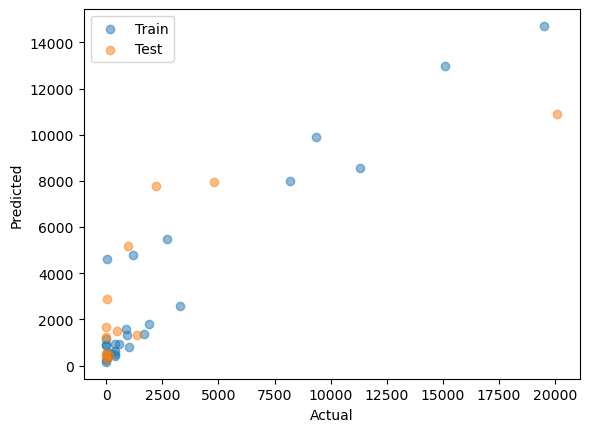

In [37]:
plt.scatter(y_train, y_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, y_pred, alpha=0.5, label='Test')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()  # Add legend

plt.savefig(image_folder + 'predicted_actual.png')  # Replace with the desired image file format

plt.show()


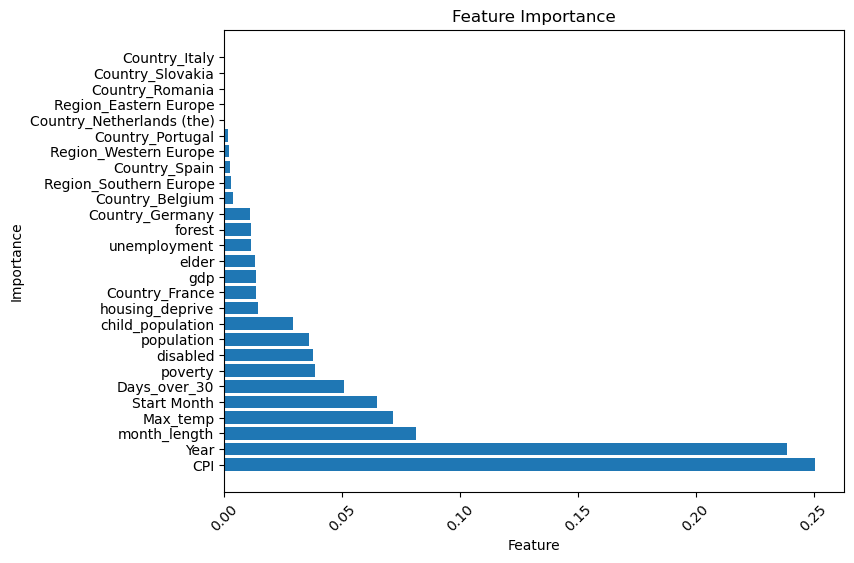

In [38]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)

plt.savefig(image_folder + 'feature_importance.png')  # Replace with the desired image file format

plt.show()

In [30]:
# explain

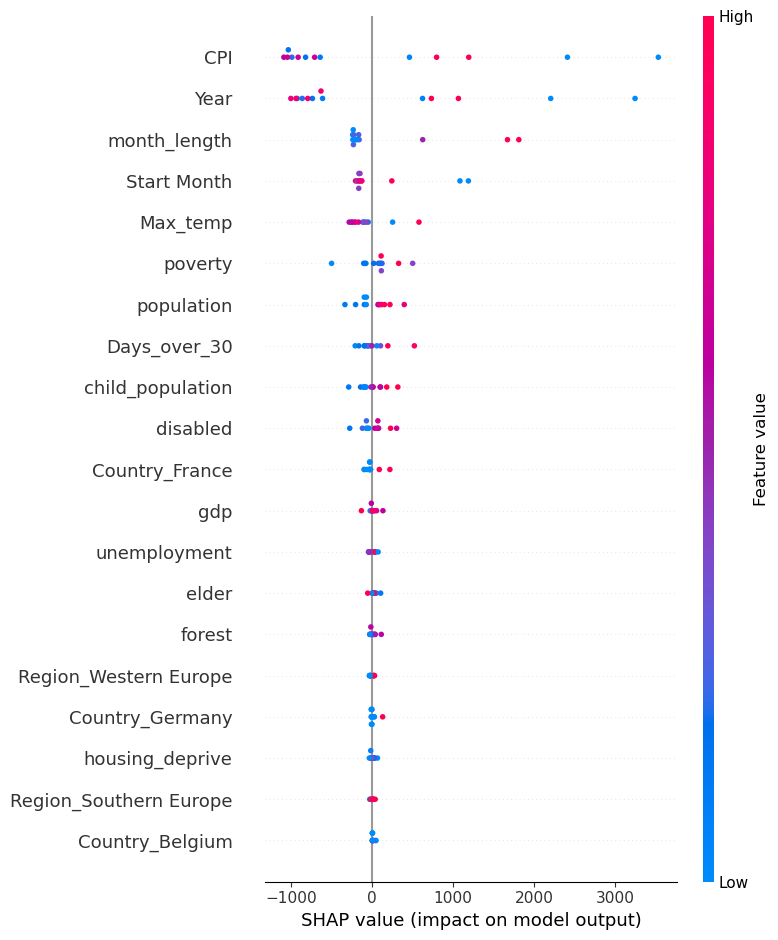

<Figure size 640x480 with 0 Axes>

In [39]:
# Calculate SHAP values
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values (e.g., summary plot)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

plt.savefig(image_folder + 'shap_summary_plot.png')